<h1> Initialize NEST and solve for LY, QY at all energies vs. Electric field</h1>

In [1]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') 
sys.path.insert(2,home_dir[0]+'/LZ_git/fastNEST/libNEST') #add to import Lib-NEST
import libNEST
from pyROOT_import import *
from LZlim_pyNEST import *
from ROOT import TH2D
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Calculate LY QY for ER </h1>

In [36]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(5000),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

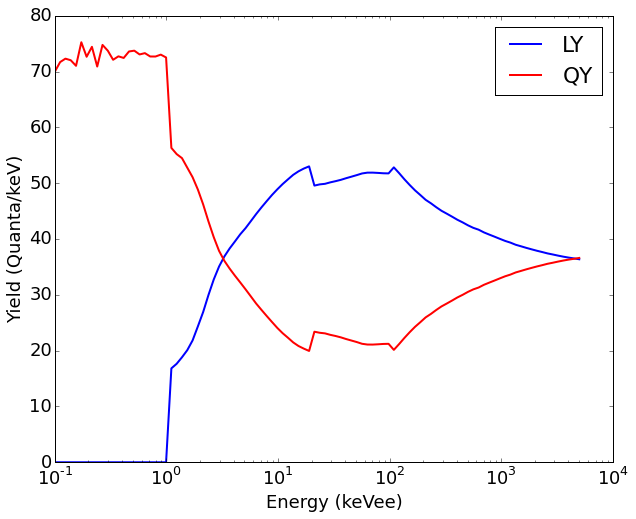

In [37]:
## semilogx(Energy,LY,linewidth=2)
semilogx(Energy,LY,'-b',linewidth=2)
semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate LY QY for NR </h1>

In [26]:
NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(300),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

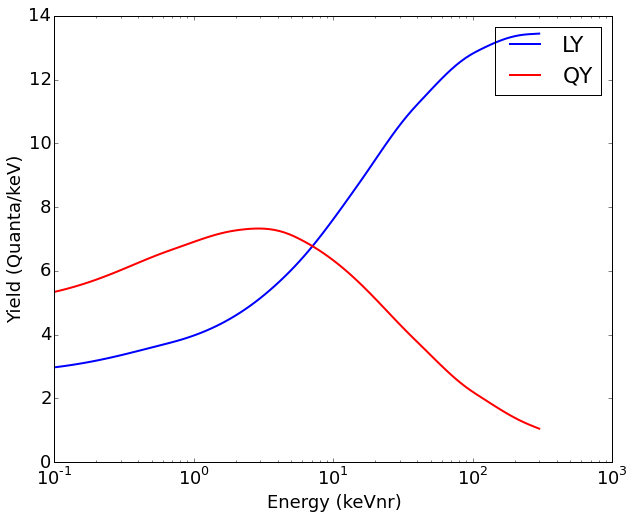

In [35]:
## semilogx(Energy,LY,linewidth=2)

#Smooth out the curve, save some compuational power
sLY = ip.UnivariateSpline(Energy, LY,s=0.1)
sQY = ip.UnivariateSpline(Energy, QY,s=0.1)

semilogx(Energy,sLY(Energy),'-b',linewidth=2)
semilogx(Energy,sQY(Energy),'-r',linewidth=2)
#semilogx(Energy,LY,'-b',linewidth=2)
#semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVnr)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate ER at multiple fields </h1>

In [61]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list=[]
QY_list=[]
Energy = logspace(-1,log10(5000),100)
Efield=array([12,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,1000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list.append(LY)
    QY_list.append(QY)

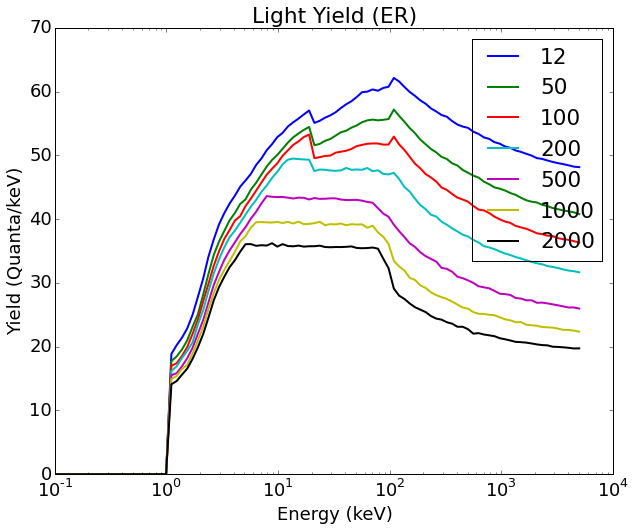

In [62]:
#Smooth out the curve, save some compuational power
#sLY = ip.UnivariateSpline(Energy, LY,s=0.1)
#sQY = ip.UnivariateSpline(Energy, QY,s=0.1)

#semilogx(Energy,sLY(Energy),'-b',linewidth=2)
#semilogx(Energy,sQY(Energy),'-r',linewidth=2)
legend_text=[]
for ii, Ef in enumerate(Efield):
    semilogx(Energy,LY_list[ii],linewidth=2)
    legend_text.append(str(Ef))
    #semilogx(Energy,QY,'-r',linewidth=2)
title('Light Yield (ER)')
xlabel('Energy (keV)')
ylabel('Yield (Quanta/keV)')
legend(legend_text)

<h1> Calculate NR at multiple fields </h1>

In [71]:
NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list=[]
QY_list=[]
Energy = logspace(-1,log10(300),100)
Efield=array([12,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,1000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list.append(LY)
    QY_list.append(QY)

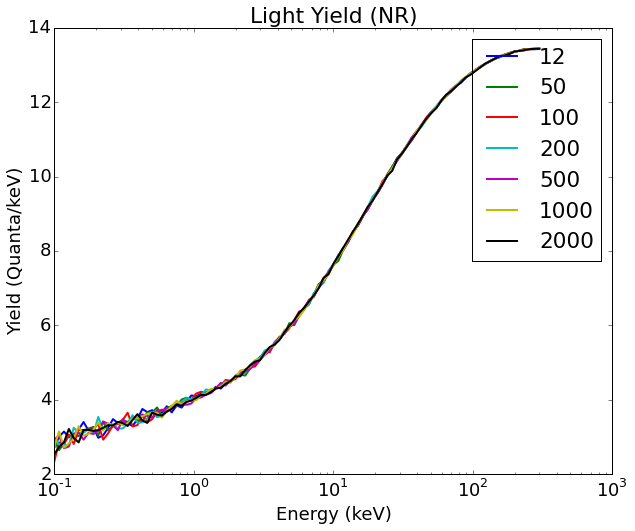

In [72]:
#Smooth out the curve, save some compuational power
#sLY = ip.UnivariateSpline(Energy, LY,s=0.1)
#sQY = ip.UnivariateSpline(Energy, QY,s=0.1)

#semilogx(Energy,sLY(Energy),'-b',linewidth=2)
#semilogx(Energy,sQY(Energy),'-r',linewidth=2)
legend_text=[]
for ii, Ef in enumerate(Efield):
    semilogx(Energy,LY_list[ii],linewidth=2)
    legend_text.append(str(Ef))
    #semilogx(Energy,QY,'-r',linewidth=2)
title('Light Yield (NR)')
xlabel('Energy (keV)')
ylabel('Yield (Quanta/keV)')
legend(legend_text)